In [ ]:
# Modified February 6, 2020

In [1]:
import sys, os

sys.path.append('/Users/ajc/codes/simulator/debug/ats-mesh/tools/meshing_ats/meshing_ats')
import meshing_ats

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal

In [2]:
xl =pd.ExcelFile('Topo_Profiles_Barrow.xlsx')

In [3]:
xl.sheet_names
print (xl.sheet_names)
data = xl.parse(sheet_name='Transect B, Area C')
keys = data.keys()
slice_at_right = False

['Transect A, Polygon near ERT', 'Transect B, Polygon near ERT', 'Transect Area B', 'Transect A, Area C', 'Transect B, Area C', 'Repeat ERT Transect']


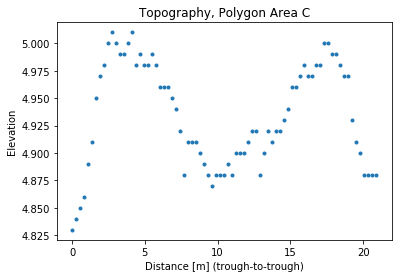

In [4]:
plt.plot(data['Distance_m'], data['Z'],'.')
plt.ylabel('Elevation')
plt.title('Topography, Polygon Area C')
plt.xlabel('Distance [m] (trough-to-trough)')
plt.show()

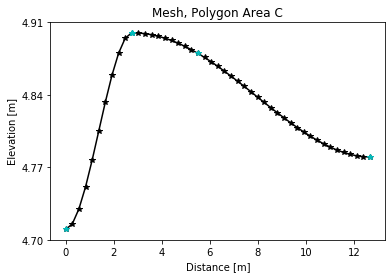

In [5]:
# smooth the topographic data : February 13 and trough cell inward oriented
length = len(data['Distance_m'])
x = []
z = []

if (slice_at_right):
    x = np.array(data['Distance_m'][length/2:])
    z = np.array(data['Z'][length/2:])
else:
    x = np.array(data['Distance_m'][:46])
    z = np.array(data['Z'][:46])

z = [z1 - 0.1127955 for z1 in z] # match the trough's elevation with the "trough elevation" from water-table data 
A1 = []
A1 = np.insert(x, 0, -x[1])
x = np.array([a + x[1] for a in A1])
z = np.insert(z,0, z[0]+.0000)


# This is the topography used in the paper: February 6, 2020
rim = 4.9
x1_N3 = [x[0], x[10]]
z1_N3 = [4.71, rim]
x2_N3 = [x[10], x[20], x[-1]]
z2_N3 = [rim, rim-0.02, 4.78]
cs1 = scipy.interpolate.CubicSpline(x1_N3,z1_N3, bc_type='clamped')
cs2 = scipy.interpolate.CubicSpline(x2_N3,z2_N3, bc_type='clamped')

#z_smooth_N3 = np.concatenate((cs1(x[:11]), cs2(x[11:])))
#z_smooth_N3 = np.array([round(s,4) for s in z_smooth_N3])

#z_left = z_smooth_N3
#xx = x1_N3 + x2_N3
#zz = z1_N3 + z2_N3

z_smooth = np.concatenate((cs1(x[:11]), cs2(x[11:])))

if (slice_at_right):
    z = z[::-1]
    z_smooth = z_smooth[::-1]
    x = x[::-1]

z_smooth = np.array([round(s,4) for s in z_smooth])

#plt.plot(x, z, '.', color='r')
plt.plot(x, z_smooth, '-*', color = 'k')
plt.plot(x1_N3,z1_N3,'*', color='c')
plt.plot(x2_N3,z2_N3,'*', color='c')
#plt.plot(x3,z3,'*', color='c')
#plt.plot(x4,z4,'.', color='g')
plt.ylabel('Elevation [m]')
plt.xlabel('Distance [m]')
plt.title('Mesh, Polygon Area C')
plt.ylim(4.7,4.91)
plt.yticks(np.linspace(4.7,4.91,4))
plt.show()


In [6]:
import math
def Distance(x,y):
    d = np.zeros(len(x))
    for i in range(len(x)):
        d[i] = math.hypot(x[-1] - x[i], y[-1] - y[i])
    return d

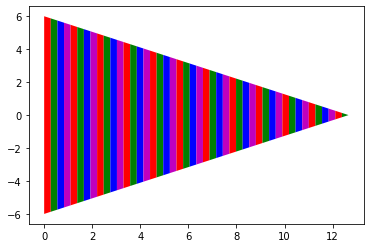

In [9]:
#reload(meshing_ats)
site_area = 'C'
if site_area == 'A':
    arclen = 16 
elif site_area == 'B':
    arclen = 6 
elif site_area == 'C':
    arclen = 12
elif site_area == 'D':
    arclen = 10

m2 = meshing_ats.Mesh2D.from_Transect_MakePieWedge(x,z_smooth, arclen, curved=False)
m2.plot()
#print site_area, arclen

In [ ]:
print z_smooth
maxloc = int(xloc[0])
trough_mid = (z_smooth[0] + z_smooth[maxloc]) / 2.0 #xloc is the location of the max z
trough = [x1 for x1 in z_smooth[:maxloc+1] if x1 < trough_mid]
print trough, len(trough), trough_mid

rim_mid = (z_smooth[xloc] + z_smooth[-1]) / 2.0
rim_mid_loc = np.where(z_smooth[10:] <= rim_mid)[-1]
print 'Rim mid loc',rim_mid_loc[-1]
rim = [x1 for x1 in z_smooth[:maxloc +1] if (x1 >=trough_mid) ]
for x1 in z_smooth[maxloc+1:]:
    if x1 > rim_mid:
        rim.append(x1)
print rim, len(rim), rim_mid

center = [round(x1,4) for x1 in z_smooth[maxloc:] if x1 <= rim_mid]
print center, len(center)

l1 = len(trough)
l2 = len(center)-2

peat = np.concatenate((trough, rim, center))
print len(x), len(peat)



In [ ]:
#Changing organic layer thickness 
#AreaC_OM = [center : 10 cm , rim : 10cm, trough : 16 cm]
def org_layer_bottom_bndry(topo_pos, i):
    if (topo_pos in trough and i <maxloc):
        thickness = 0.14
    elif(topo_pos in rim and i < rim_mid_loc[-1]):
        thickness = 0.08
    elif (topo_pos in center):
        thickness = 0.20
    return thickness

In [ ]:
peat_thickness = [org_layer_bottom_bndry(p,i) for i,p in enumerate(peat)]
fig, ax = plt.subplots()
ax.plot(x, peat, 'g*')
ax.plot(x,z_smooth, 'r.')
ax1 = ax.twinx()
ax1.plot(x,peat_thickness, 'c-')


In [ ]:
outfile = "/Users/ajc/Desktop/ATS/meshes/barrow-pie-wedges/"
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

z=0
Z = []

for i in range(1):
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1001)
    z = z + 0.02
    Z.append(z)
print ('Moss ', z)

for i in range(4):
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1002)
    z = z + 0.02
    Z.append(z)
print ('Peat ', z)

for i in range(15): 
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1003)
    z = z + 0.02
    Z.append(z)
print ('Upper mineral ', z)

dz = .02
for i in range(35):
    dz *= 1.075
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1003)
    z = z + dz
    Z.append(z)
print ('Ice rich', z)

for i in range(25):
    dz *= 1.12
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1003)
    z = z + dz
    Z.append(z)
print (z)


layer_types.append('snapped')
layer_data.append(-45.0) # bottom location
layer_ncells.append(1)
layer_mat_ids.append(1003)

m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types, 
                                        layer_data, 
                                        layer_ncells, 
                                        layer_mat_ids)

#m3.write_exodus(outfile + "areaC-updist-vladimir-om10cm.exo")
m3.write_exodus(outfile + "areaC-3layers-diver-om10cm-l.exo")
#m3.write_exodus(outfile + "column-3layers-om10cm.exo")

In [ ]:
#variable peat thickness

outfile = "/Users/ajc/Desktop/ATS/meshes/barrow-pie-wedges/"
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

z=0
Z = []

for i in range(1):
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1001*np.ones((m2.num_cells(),),'i'))
    z = z + 0.02
    Z.append(z)
print ('Moss ', z)

for i in range(9):
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(-1000*np.ones((m2.num_cells(),),'i'))
    z = z + 0.02
    Z.append(z)
print ('Peat ', z)

for i in range(10): 
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
    z = z + 0.02
    Z.append(z)
print ('Upper mineral ', z)

dz = .02
for i in range(35):
    dz *= 1.075
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
    z = z + dz
    Z.append(z)
print ('Ice rich', z)

for i in range(25):
    dz *= 1.12
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
    z = z + dz
    Z.append(z)
print (z)


layer_types.append('snapped')
layer_data.append(-45.0) # bottom location
layer_ncells.append(1)
layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))


mat_ids=np.zeros((m2.num_cells(), 11), 'i')

for i in range(m2.num_cells()):
    for j in range(11):
        if (Z[j]<=peat_thickness[i]):
            mat_ids[i,j]=1002
        else:
            mat_ids[i,j]=1003
for j in range(11):
    layer_mat_ids[j] = mat_ids[:,j]

print len(layer_mat_ids), len(layer_ncells), len(layer_types), len(layer_data)


m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types, 
                                        layer_data, 
                                        layer_ncells, 
                                        layer_mat_ids)


m3.write_exodus(outfile + "areaC-3layers-diver-om10cm.exo")






In [ ]:
# Old z resolution -- November 8, 2018
outfile = "/Users/ajc/Desktop/ATS/meshes/barrow-pie-wedges/"
# layer extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

z=0
Z = []

for i in range(2):
    layer_types.append('constant')
    layer_data.append(0.01)
    layer_ncells.append(1)
    layer_mat_ids.append(1001)
    z = z + 0.01
    Z.append(z)
print ('Moss ', z)

for i in range(4): 
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1002)
    z = z + 0.02
    Z.append(z)
print ('Peat ', z)

for i in range(20): #8cm peat, n=20, 20cm peat n = 14
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1003)
    z = z + 0.02
    Z.append(z)
print (z)


dz = .02
for i in range(21):
    dz *= 1.05
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1003)
    z = z + dz
    Z.append(z)
print (z)

for i in range(17):
    dz *= 1.2
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1003)
    z = z + dz
    Z.append(z)
print (z)

for i in range(8):
    dz *= 1.2
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1003)
    #print ('5th layer',z)
    z = z + dz
    Z.append(z)
print (Z)
print len(Z)
layer_types.append('snapped')
layer_data.append(-40.0) # bottom location
layer_ncells.append(2)
layer_mat_ids.append(1003)

#print layer_data
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types, 
                                        layer_data, 
                                        layer_ncells, 
                                        layer_mat_ids)

#m3.write_exodus(outfile + "areaC-updist-vladimir-om10cm.exo")
m3.write_exodus(outfile + "areaC-smooth-om10cm.exo")